<style>
.todo {color: red;}
.tit { 
    text-align: left; 
    font-family: Arial Black; 
    font-weight: bold; 
    font-size: 50px; 
    color: #06cc70; 
    text-shadow: -1px 0 #000, 0 1px #000, 3px 0 #000, 0 -1px #000;
}
</style>

<h1 class="tit">Data storage and persistence</h1>
<span class="todo">TODO - Introduction</span>

Several data persistence alternatives have been proposed, in this notebook an attempt is made to create a wiki with documentation on this task.

# **1 - Storage methods**

## **1.1 - Using files**

### 1.1.1 JSON

As a proposal for file storage, we propose the use of JSON files. JSON files are a common way to store data in a human readable format. They are also easy to parse and manipulate. The following example shows how to store a dictionary in a JSON file.


To store the network of dependencies we are going to represent all the packages and their dependencies in a Python dictionary. For this, we are going to use the json library.
The following example shows how to perform this process.

## **1.2 - Using database**

<style>.green {color: green; font-weight: bold}</style>
With the objective in mind of developing a web version of olivia, a database has been implemented to store the network of <span class="green">CRAN and Bioconductor</span> dependencies, one of the most important repositories of R.

To manage the database, a class <span class="lib">DatabaseHandler</span> has been implemented capable of being functional using different database engines using the abstract factory design pattern and guaranteeing the existence of a single instance of the class using the singleton pattern

Entity relationship diagram for the proposed database


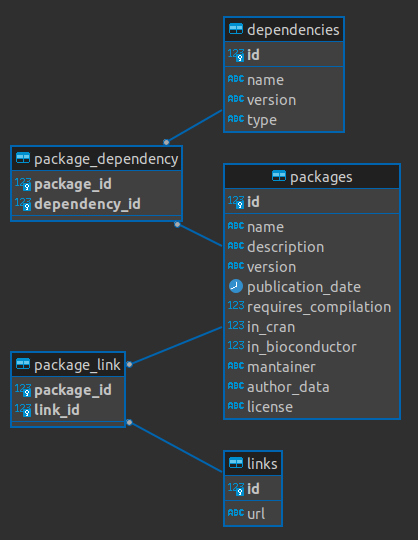

### 1.2 - MySQL

#### 1.2.1 - Implementation of the database model

First of all, we make sure that we have the necessary dependencies installed.

In [1]:
%pip install sqlalchemy
%pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Load the sqlalchemy libraries

In [3]:
from sqlalchemy import create_engine, Column, Integer, String, Text, Boolean, Date, ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship

We define the connection parameters to the database

In [4]:
db_connector =  "mysql+mysqlconnector"
db_user      =  "olivia"
db_passwd    =  "aCkj$h!EACr6/#PZ"
db_host      =  "localhost"
db_name      =  "r_network"

Create the database engine

In [13]:
engine = create_engine(db_connector + "://" + db_user + ":" + db_passwd + "@" + db_host + "/" + db_name)

Implementation of the database model

In [6]:
Base = declarative_base()

class Package_MySQL(Base):
    __tablename__ = 'packages'
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String(255), nullable=False)
    description = Column(Text)
    version = Column(String(255), nullable=False)
    publication_date = Column(Date, nullable=False)
    requires_compilation = Column(Boolean, nullable=False)
    in_cran = Column(Boolean)
    in_bioconductor = Column(Boolean)
    mantainer = Column(String(255), nullable=False)
    author_data = Column(Text)
    license = Column(String(255), nullable=False)
    dependencies = relationship('Dependency_MySQL', secondary='package_dependency')
    links = relationship('Link_MySQL', secondary='package_link')

class Dependency_MySQL(Base):
    __tablename__ = 'dependencies'
    id = Column(Integer, primary_key=True, autoincrement=True)
    name = Column(String(255), nullable=False)
    version = Column(String(255), nullable=False)
    type = Column(String(255), nullable=False)

class PackageDependency_MySQL(Base):
    __tablename__ = 'package_dependency'
    package_id = Column(Integer, ForeignKey('packages.id'), primary_key=True)
    dependency_id = Column(Integer, ForeignKey('dependencies.id'), primary_key=True)

class Link_MySQL(Base):
    __tablename__ = 'links'
    id = Column(Integer, primary_key=True, autoincrement=True)
    url = Column(String(255), nullable=False)

class PackageLink_MySQL(Base):
    __tablename__ = 'package_link'
    package_id = Column(Integer, ForeignKey('packages.id'), primary_key=True)
    link_id = Column(Integer, ForeignKey('links.id'), primary_key=True)

Create the representation of the model (If you have already done it, do not do it again)

In [ ]:
Base.metadata.create_all(engine)

Delete the database

In [ ]:
Base.metadata.drop_all(engine)

Create a session

In [9]:
from sqlalchemy.orm import sessionmaker

In [59]:
# create session
Session = sessionmaker(bind=engine)
session = Session()

insert a package

In [65]:
# insert package
package = Package_MySQL(
    name="pakage_test", 
    description="lore ipsum dolor sit amet", 
    version="1.0.0", 
    publication_date="2023-01-01", 
    requires_compilation=True, 
    in_cran=True, 
    in_bioconductor=False, 
    mantainer="Fulanito de tal", 
    author_data="lore ipsum dolor sit amet", 
    license="license"
)
session.add(package)
session.commit()

# insert dependency
dependency = Dependency_MySQL(name="dependency_test", version="1.0.0", type="type")
session.add(dependency)
session.commit()

# insert package_dependency
package_dependency = PackageDependency_MySQL(package_id=package.id, dependency_id=dependency.id)
session.add(package_dependency)
session.commit()

# insert link
link = Link_MySQL(url="http://url")
session.add(link)
session.commit()

# insert package_link
package_link = PackageLink_MySQL(package_id=package.id, link_id=link.id)
session.add(package_link)
session.commit()

Get database packages

In [85]:
# query package
package = session.query(Package_MySQL).filter(Package_MySQL.id == 1).first()

# query dependency
dependency = session.query(Dependency_MySQL).filter(Dependency_MySQL.id == 1).first()

# query package dependency
package_dependency = session.query(PackageDependency_MySQL).filter(PackageDependency_MySQL.package_id == 1).first()

# query link
link = session.query(Link_MySQL).filter(Link_MySQL.id == 1).first()

# query package link
package_link = session.query(PackageLink_MySQL).filter(PackageLink_MySQL.package_id == 1).first()

# --------------------

print("Package name: ", package.name)
print("Package description: ", package.description)
print("Package version: ", package.version)
print("Package publication date: ", package.publication_date)
print("Package requires compilation: ", package.requires_compilation)
print("Package in cran: ", package.in_cran)
print("Package in bioconductor: ", package.in_bioconductor)
print("Package mantainer: ", package.mantainer)
print("Package author data: ", package.author_data)
print("Package license: ", package.license)
print("Package dependencies: ", package.dependencies)
print("Package links: ", package.links)


Package name:  pakage_test
Package description:  description
Package version:  1.0.0
Package publication date:  2021-01-01
Package requires compilation:  True
Package in cran:  True
Package in bioconductor:  False
Package mantainer:  mantainer
Package author data:  author_data
Package license:  license
Package dependencies:  [<__main__.Dependency_MySQL object at 0x7f94c81db190>]
Package links:  [<__main__.Link_MySQL object at 0x7f94c81db4c0>]


In [19]:
# Close the session
session.close()

# **2 - Data structure Package**
<style>.todo {color: red;}</style>
<span class="todo">TODO - Introduction</span>

In [83]:
class Dependency:

    # Class constructor
    def __init__(self):
        
        self.id = None
        self.id_pkg = None
        self.name = None
        self.type = None
        self.version = None

    # String representation of the Dependency class
    def __str__(self):

        # If the dependency has a version, return the name and version
        if self.version:
            return self.name + " (" + str(self.version) + ")" + " type: " + self.type
        # If the dependency does not have a version, return the name
        else:
            return self.name + ", type: " + self.type

    # function to get the dependency from the database
    def build_from_db(self, session: Session):
            
        # Get the dependency from the database
        dependency = session.query(Dependency_MySQL).filter(Dependency_MySQL.id == self.id).first()

        # If the dependency exists, initialize the dependency
        if dependency:
            self.id = dependency.id
            self.name = dependency.name
            self.type = dependency.type
            self.version = dependency.version

    # function to save the dependency in the database
    def save(self, session: Session):

        # If the dependency does not have an id, insert it in the database
        if not self.id:
            # Insert the dependency in the database
            session.add(self)
            session.commit()

            # Get the id of the dependency
            self.id = session.query(Dependency_MySQL).filter(Dependency_MySQL.name == self.name).first().id

        # If the dependency has an id, update it in the database
        else:
            # Update the dependency in the database
            session.query(Dependency_MySQL).filter(Dependency_MySQL.id == self.id).update(
                {
                    Dependency.name: self.name,
                    Dependency.type: self.type,
                    Dependency.version: self.version
                }
            )
            session.commit()

    # function to print the data of the Dependency class
    def dump(self):

        return f'{self.type}:{self.name}_v({self.version})'

In [89]:
class Link:

    # Class constructor
    def __init__(self) -> None:

        self.id      =   None
        self.id_pkg  =   None
        self.url     =   None

    # String representation of the Link class
    def __str__(self):
        return self.url

    # function to get the link from the database
    def build_from_db(self, session: Session):
            
        # Get the link from the database
        link = session.query(Link_MySQL).filter(Link_MySQL.id == self.id).first()

        # If the link exists, initialize the link
        if link:
            self.id = link.id
            self.url = link.url

    # function to save the link in the database
    def save_in_db(self, session: Session):

        # If the link does not have an id, insert it in the database
        if not self.id:
            # Insert the link in the database
            session.add(self)
            session.commit()

            # Get the id of the link
            self.id = session.query(Link).filter(Link.url == self.url).first().id

        # If the link has an id, update it in the database
        else:
            # Update the link in the database
            session.query(Link).filter(Link.id == self.id).update(
                {
                    Link.url: self.url
                }
            )
            session.commit()

    # function to update the link in the database
    def update_in_db(self, session: Session):
            
        # Update the link in the database
        session.query(Link_MySQL).filter(Link_MySQL.id == self.id).update(
            {
                Link_MySQL.url: self.url
            }
        )
        session.commit()

    # function to print the data of the Link class
    def dump(self):
        
        return f'{self.url}'

In [87]:
class Package:
 
    # Constructor
    def __init__(self, name):
  
        self.id = None
        self.name = name
        self.description = None
        self.version = None
        self.publication_date = None
        self.mantainer = None
        self.author_data = None
        self.dependencies : list[Dependency] = []
        self.license = None
        self.requires_compilation = None
        self.in_cran = True
        self.in_bioc = None
        self.links = []

    # Makes a representation of the object in a readable form
    def __str__(self):
        return self.name + " " + self.version

    # Prints a representation of the object in stdout
    def dump(self):

        mantainers_str = self.mantainer
        dependencies_str = "\n".join(f"  - {dep}" for dep in self.dependencies)
        links_str = "\n".join(f"  - {link}" for link in self.links)

        package_str = f"""\
Name: {self.name}
Description:
{self.description or "None"}
Version: {self.version or "None"}
Publication date: {self.publication_date or "None"}
Mantainer: {mantainers_str or "None"}
Authors:
{self.author_data or "None"}
Dependencies:
{dependencies_str or "None"}
Requires compilation: {self.requires_compilation or "None"}
In CRAN: {self.in_cran or "None"}
In Bioconductor: {self.in_bioc or "None"}
Licenses:
{self.license or "None"}
Links:
{links_str or "None"}
"""
        print(package_str)

    # Build the object from the information in the database
    def build_from_db(self, session: Session) -> bool:

        # Get the package from the database
        package = session.query(Package_MySQL).filter(Package_MySQL.name == self.name).first()

        # If the package is not in the database, return False
        if package is None:
            return False
        
        # If the package is in the database, build the object
        self.id = package.id
        self.name = package.name
        self.description = package.description
        self.version = package.version
        self.publication_date = package.publication_date
        self.mantainer = package.mantainer
        self.author_data = package.author_data
        self.requires_compilation = package.requires_compilation
        self.in_cran = package.in_cran
        self.in_bioc = package.in_bioconductor
        self.license = package.license

        # Get the dependencies from the database
        self.dependencies = []
        pkg_dep_relationships = session.query(PackageDependency_MySQL).filter(PackageDependency_MySQL.package_id == self.id).all()
        for rel in pkg_dep_relationships:
            # Build the dependency object using class method
            dependency_obj = Dependency()
            dependency_obj.id = rel.dependency_id
            dependency_obj.build_from_db(session)
            # Add the dependency to the list of dependencies
            self.dependencies.append(dependency_obj)

        # Get the links from the database
        self.links = []
        links = session.query(PackageLink_MySQL).filter(PackageLink_MySQL.package_id == self.id).all()
        for link in links:
            # Build the link object using class method
            link_obj = Link()
            link_obj.id = link.link_id
            link_obj.build_from_db(session)
            # Add the link to the list of links
            self.links.append(link_obj)

        return True
    
    # Save to database
    def save_in_db(self, session: Session) -> bool:
        '''
        Save the package in the database.

        Parameters
        ----------
        session : Session
            Session to the database

        Returns
        -------
        Boolean
            True if the package was saved in the database, False otherwise
        '''

        # Check if the package is already in the database
        # ----------------------------------------------
        if self.id is not None:
            return False

        # Create the package in the database
        # ----------------------------------
        package = Package_MySQL(self.name, self.description, self.version, self.publication_date, self.mantainer, self.author_data, self.requires_compilation, self.in_cran, self.in_bioc)
        session.add(package)
        session.commit()

        # Get the package id
        self.id = session.query(Package_MySQL).filter(Package_MySQL.name == self.name).first().id

        # Save the dependencies in the database
        for dependency in self.dependencies:
            dependency.save_in_db(session, self.id)

        # Save the licenses in the database
        for license in self.license:
            license.save_in_db(session, self.id)

        # Save the links in the database
        for link in self.links:
            link.save_in_db(session, self.id)

        return True

    # Update the package in the database
    def update_in_db(self, session: Session) -> bool:
        '''
        Update the package in the database.

        Parameters
        ----------
        session : Session
            Session to the database

        Returns
        -------
        Boolean
            True if the package was updated in the database, False otherwise
        '''

        # Check if the package is in the database
        # ---------------------------------------
        if self.id is None:
            return False

        # Update the package in the database
        # ----------------------------------
        package = session.query(Package_MySQL).filter(Package_MySQL.id == self.id).first()

        package.name = self.name
        package.description = self.description
        package.version = self.version
        package.publication_date = self.publication_date
        package.mantainer = self.mantainer
        package.authors_data = self.author_data
        package.requires_compilation = self.requires_compilation
        package.in_cran = self.in_cran
        package.in_bioc = self.in_bioc

        session.commit()

        # Update the dependencies in the database
        for dependency in self.dependencies:
            dependency.update_in_db(session, self.id)

        # Update the licenses in the database
        for license in self.license:
            license.update_in_db(session, self.id)

        # Update the links in the database
        for link in self.links:
            link.update_in_db(session, self.id)

        return True
   

In [90]:
# Create a package
package_test = Package("pakage_test")
package_test.build_from_db(session)

# Print the package
package_test.dump()

Name: pakage_test
Description:
description
Version: 1.0.0
Publication date: 2021-01-01
Mantainer: mantainer
Authors:
author_data
Dependencies:
  - dependency_test (1.0.0) type: type
Requires compilation: True
In CRAN: True
In Bioconductor: None
Licenses:
license
Links:
  - http://url

